# **Convolutional Neural Network**

## **Download Data**

In [ ]:
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip

## **Import Packages**

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import v2
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt

/Users/complexa/anaconda3/envs/complexa_ML21_3a/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/complexa/anaconda3/envs/complexa_ML21_3a/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to use

## **Tools for Semi-Supervised Learning**

In [2]:
class Custom_DatasetFolder(DatasetFolder):
    '''This customized class is used for unlabeled training data'''
    def __init__(self, root, loader, extension, transform):
        super().__init__(root=root, loader=loader, extensions=extension, transform=transform)
    
    
    def __getitem__(self, index):
        '''This method had been overriden'''

        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, self.targets[index]
    
    def set_label(self, index, label):
        self.targets[index] = label

    '''Alternative Solution - not override the __getitem__ method
    def set_label(self, index, label):
        # TODO : check whether the input index is valid
        #
        #

        temp_sample = self.samples[index] # a tuple (path : str, label : int)
        temp_sample = list(temp_sample)
        temp_sample[1] = label
        self.samples[index] = tuple(temp_sample)
    '''


def get_pseudo_labels(dataset, model, batch_size, device="cpu", threshold=0.65):
    '''This function generate pseudo-labels of a (unlabeled) dataset using given model.
       It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
       '''
    model.eval()
    sofmax = nn.Softmax(dim=-1)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print("get_pseudo_labels(...) activate ...")

    # indices list to record those samples' indices in dataset for which predicted probabilities pass threshold
    idx_lst = []

    for batch_idx, (imgs, null_labels) in enumerate(data_loader):

        '''Testing'''
        if batch_idx > 2:
            break

        # forward the data
        with torch.no_grad():
            logits = model(imgs.to(device))
        
        # optain the probability distributions by applying softmax on logits
        probs = sofmax(logits)

        # get maximum probability & corresponding class of each sample
        max_probs_class = probs.max(dim=-1)
        max_probs_lst = max_probs_class[0].tolist()
        max_class_lst = max_probs_class[1].tolist()

        # loop through all samples in a batch, and select those samples that pass threshold
        for i in range(len(max_probs_lst)):
            
            if max_probs_lst[i] >= threshold:

                # calculate the corresponding index of dataset
                corrected_idx = i + batch_idx * data_loader.batch_size

                idx_lst.append(corrected_idx)

                # assign label to sample that exceeds threshold
                dataset.set_label(corrected_idx, max_class_lst[i])

    return Subset(dataset, idx_lst)

## **Dataset, Data Loader, and Transforms**

In [3]:
batch_size = 128

# transformation for training data
# resize the image to (height, width)=(128, 128)
train_tfm_origin = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor()
])
# data augmentation
train_tfm_augmen = v2.Compose([
    v2.Resize((128, 128)),
    # ----TODO----
    # add more transforms for data augmentation
    v2.RandomHorizontalFlip(1),
    v2.ToTensor()
])

# transformation for testing data
# resize the image to (height, width)=(128, 128)
test_tfm = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor()
])

# dataset augmentation
train_lb_dataset_origin = DatasetFolder("./food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm_origin)
train_lb_dataset_augmen = DatasetFolder("./food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm_augmen)
train_lb_dataset = ConcatDataset([train_lb_dataset_origin, train_lb_dataset_augmen])
train_unlb_dataset = Custom_DatasetFolder("./food-11/training/unlabeled", lambda x: Image.open(x), "jpg", train_tfm_origin)
valid_lb_dataset = DatasetFolder("./food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_dataset = DatasetFolder("./food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# dataloaders
train_loader = DataLoader(train_lb_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_lb_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"training data (labeled) size: {len(train_lb_dataset)}")
print(f"training data (unlabeled) size: {len(train_unlb_dataset)}")
print(f"validation data size: {len(valid_lb_dataset)}")
print(f"testing data size: {len(test_dataset)}")

training data (labeled) size: 6160
training data (unlabeled) size: 6786
validation data size: 660
testing data size: 3347


/Users/complexa/anaconda3/envs/complexa_ML21_3a/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## **Model**

In [4]:
class Food11_ImgClassifier(nn.Module):
    def __init__(self):
        super(Food11_ImgClassifier, self).__init__()
        
        # input image size : (c, h, w) = (3, 128, 128)
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )

        # fully-connected layers
        # output 11 classes
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # inpurt (x) : [batch_size, 3, 128, 128]
        # output : [batch_size, 11]
        
        # extract features by convolutional layers
        x = self.cnn_layers(x)

        # the extracted feature map must be flatten before going to fully-connected layers
        # dim-0 is for batch_size, which need not be flattened
        x = x.flatten(1)

        x = self.fc_layers(x)
        return x

## **Training**

In [5]:
do_semi = True
n_epochs = 60 # number of training epochs

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device : {device}")

# initialize a model, and put it on the device specified
model = Food11_ImgClassifier().to(device)
model.device = device

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5) # fine-tune some hyperparameters for better performance

# plotting
epoch_loss = {"train" : [], "valid" : []}
epoch_accu = {"train" : [], "valid" : []}

# model check point
model_ckpt_path = "./model.ckpt"
best_accu = 0.0

# start training
for epoch in range(n_epochs):

    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi:
        # obtain pseudo-labels for unlabeled data using trained model
        pseudo_lb_dataset = get_pseudo_labels(train_unlb_dataset, model, batch_size, device)
        concat_dataset = ConcatDataset([train_lb_dataset, pseudo_lb_dataset])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        print(f"pseudo set size : {len(pseudo_lb_dataset)}")
        print(f"unlabeled set size : {len(train_unlb_dataset)}")
        print(f"training set size : {len(concat_dataset)}")

    # ----------Training----------
    model.train()

    train_loss = []
    train_accs = []

    print("start training ...")

    for batch in tqdm(train_loader):
        
        imgs, labels = batch

        # forward the data
        logits = model(imgs.to(device))

        # no need to apply softmax before computing cross-entropy as it is done automatically
        loss = criterion(logits, labels.to(device))

        # gradients stored in the parameters in the previous step should be cleared
        optimizer.zero_grad()

        # compute the gradients for parameters
        loss.backward()

        # clip the gradient norms for stable training
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # update the parameters with computed gradients
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).cpu().float().mean()
        train_loss.append(loss.cpu().item())
        train_accs.append(acc)
    
    train_loss = sum(train_loss) / len(train_loss)
    train_accu = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_accu:.5f}")

    # ----------Validation----------
    model.eval()

    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):
        imgs, labels = batch

        with torch.no_grad():
            logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).cpu().float().mean()

        valid_loss.append(loss.cpu().item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accu = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_accu:.5f}")

    # check point
    if valid_accu > best_accu:
        best_accu = valid_accu
        torch.save(model.state_dict(), model_ckpt_path)
        print(f"Saving model ... | Valid Accu : {valid_accu:.5f}")
        
    # record loss and accuracy in each epoch
    epoch_loss["train"].append(train_loss)
    epoch_accu["train"].append(train_accu)
    
    epoch_loss["valid"].append(valid_loss)
    epoch_accu["valid"].append(valid_accu)



device : mps
get_pseudo_labels(...) activate ...
pseudo set size : 0
unlabeled set size : 6786
training set size : 6160
start training ...


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 001/060 ] loss = 2.10316, acc = 0.25717


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 001/060 ] loss = 2.56650, acc = 0.14974
Saving model ... | Valid Accu : 0.14974
get_pseudo_labels(...) activate ...
pseudo set size : 4
unlabeled set size : 6786
training set size : 6164
start training ...


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 002/060 ] loss = 1.70370, acc = 0.40140


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 002/060 ] loss = 1.76341, acc = 0.40573
Saving model ... | Valid Accu : 0.40573
get_pseudo_labels(...) activate ...
pseudo set size : 24
unlabeled set size : 6786
training set size : 6184
start training ...


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 003/060 ] loss = 1.49723, acc = 0.48026


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 003/060 ] loss = 1.53520, acc = 0.46979
Saving model ... | Valid Accu : 0.46979
get_pseudo_labels(...) activate ...
pseudo set size : 45
unlabeled set size : 6786
training set size : 6205
start training ...


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 004/060 ] loss = 1.33011, acc = 0.53797


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 004/060 ] loss = 1.40460, acc = 0.51276
Saving model ... | Valid Accu : 0.51276
get_pseudo_labels(...) activate ...
pseudo set size : 80
unlabeled set size : 6786
training set size : 6240
start training ...


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 005/060 ] loss = 1.16321, acc = 0.59885


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 005/060 ] loss = 1.36480, acc = 0.54479
Saving model ... | Valid Accu : 0.54479
get_pseudo_labels(...) activate ...
pseudo set size : 126
unlabeled set size : 6786
training set size : 6286
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 006/060 ] loss = 1.02870, acc = 0.64694


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 006/060 ] loss = 1.49809, acc = 0.49766
get_pseudo_labels(...) activate ...
pseudo set size : 113
unlabeled set size : 6786
training set size : 6273
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 007/060 ] loss = 0.99925, acc = 0.66953


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 007/060 ] loss = 1.43604, acc = 0.50885
get_pseudo_labels(...) activate ...
pseudo set size : 120
unlabeled set size : 6786
training set size : 6280
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 008/060 ] loss = 0.81462, acc = 0.72734


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 008/060 ] loss = 1.44947, acc = 0.53021
get_pseudo_labels(...) activate ...
pseudo set size : 167
unlabeled set size : 6786
training set size : 6327
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 009/060 ] loss = 0.68708, acc = 0.77335


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 009/060 ] loss = 1.48529, acc = 0.49844
get_pseudo_labels(...) activate ...
pseudo set size : 203
unlabeled set size : 6786
training set size : 6363
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 010/060 ] loss = 0.57114, acc = 0.81698


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 010/060 ] loss = 1.68648, acc = 0.50026
get_pseudo_labels(...) activate ...
pseudo set size : 228
unlabeled set size : 6786
training set size : 6388
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 011/060 ] loss = 0.50334, acc = 0.83860


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 011/060 ] loss = 1.46341, acc = 0.55651
Saving model ... | Valid Accu : 0.55651
get_pseudo_labels(...) activate ...
pseudo set size : 214
unlabeled set size : 6786
training set size : 6374
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 012/060 ] loss = 0.42517, acc = 0.86745


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 012/060 ] loss = 1.49770, acc = 0.55911
Saving model ... | Valid Accu : 0.55911
get_pseudo_labels(...) activate ...
pseudo set size : 219
unlabeled set size : 6786
training set size : 6379
start training ...


  0%|          | 0/50 [00:00<?, ?it/s]

[ Train | 013/060 ] loss = 0.32035, acc = 0.90357


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 013/060 ] loss = 1.62484, acc = 0.57188
Saving model ... | Valid Accu : 0.57188
get_pseudo_labels(...) activate ...
pseudo set size : 251
unlabeled set size : 6786
training set size : 6411
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 014/060 ] loss = 0.26253, acc = 0.92827


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 014/060 ] loss = 1.67840, acc = 0.55130
get_pseudo_labels(...) activate ...
pseudo set size : 287
unlabeled set size : 6786
training set size : 6447
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 015/060 ] loss = 0.20118, acc = 0.94706


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 015/060 ] loss = 1.76784, acc = 0.55990
get_pseudo_labels(...) activate ...
pseudo set size : 290
unlabeled set size : 6786
training set size : 6450
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 016/060 ] loss = 0.14485, acc = 0.96681


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 016/060 ] loss = 1.75816, acc = 0.56432
get_pseudo_labels(...) activate ...
pseudo set size : 321
unlabeled set size : 6786
training set size : 6481
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 017/060 ] loss = 0.13168, acc = 0.96881


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 017/060 ] loss = 1.91008, acc = 0.53984
get_pseudo_labels(...) activate ...
pseudo set size : 324
unlabeled set size : 6786
training set size : 6484
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 018/060 ] loss = 0.11094, acc = 0.97564


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 018/060 ] loss = 1.96425, acc = 0.55469
get_pseudo_labels(...) activate ...
pseudo set size : 338
unlabeled set size : 6786
training set size : 6498
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 019/060 ] loss = 0.09281, acc = 0.98154


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 019/060 ] loss = 1.96612, acc = 0.56120
get_pseudo_labels(...) activate ...
pseudo set size : 340
unlabeled set size : 6786
training set size : 6500
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 020/060 ] loss = 0.05699, acc = 0.99077


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 020/060 ] loss = 2.20127, acc = 0.51849
get_pseudo_labels(...) activate ...
pseudo set size : 346
unlabeled set size : 6786
training set size : 6506
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 021/060 ] loss = 0.05857, acc = 0.99127


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 021/060 ] loss = 2.26720, acc = 0.51953
get_pseudo_labels(...) activate ...
pseudo set size : 342
unlabeled set size : 6786
training set size : 6502
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 022/060 ] loss = 0.06516, acc = 0.98617


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 022/060 ] loss = 2.14365, acc = 0.54818
get_pseudo_labels(...) activate ...
pseudo set size : 365
unlabeled set size : 6786
training set size : 6525
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 023/060 ] loss = 0.03594, acc = 0.99509


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 023/060 ] loss = 2.18055, acc = 0.55781
get_pseudo_labels(...) activate ...
pseudo set size : 366
unlabeled set size : 6786
training set size : 6526
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 024/060 ] loss = 0.01885, acc = 0.99893


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 024/060 ] loss = 2.10235, acc = 0.57995
Saving model ... | Valid Accu : 0.57995
get_pseudo_labels(...) activate ...
pseudo set size : 370
unlabeled set size : 6786
training set size : 6530
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 025/060 ] loss = 0.07323, acc = 0.99023


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 025/060 ] loss = 2.19040, acc = 0.58255
Saving model ... | Valid Accu : 0.58255
get_pseudo_labels(...) activate ...
pseudo set size : 372
unlabeled set size : 6786
training set size : 6532
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 026/060 ] loss = 0.06992, acc = 0.98122


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 026/060 ] loss = 2.76442, acc = 0.53464
get_pseudo_labels(...) activate ...
pseudo set size : 346
unlabeled set size : 6786
training set size : 6506
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 027/060 ] loss = 0.13599, acc = 0.95950


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 027/060 ] loss = 2.30441, acc = 0.53229
get_pseudo_labels(...) activate ...
pseudo set size : 362
unlabeled set size : 6786
training set size : 6522
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 028/060 ] loss = 0.06705, acc = 0.98359


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 028/060 ] loss = 2.38335, acc = 0.56484
get_pseudo_labels(...) activate ...
pseudo set size : 370
unlabeled set size : 6786
training set size : 6530
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 029/060 ] loss = 0.06225, acc = 0.98483


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 029/060 ] loss = 2.41582, acc = 0.56953
get_pseudo_labels(...) activate ...
pseudo set size : 378
unlabeled set size : 6786
training set size : 6538
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 030/060 ] loss = 0.04344, acc = 0.98933


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 030/060 ] loss = 2.40117, acc = 0.57318
get_pseudo_labels(...) activate ...
pseudo set size : 378
unlabeled set size : 6786
training set size : 6538
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 031/060 ] loss = 0.02489, acc = 0.99579


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 031/060 ] loss = 2.36294, acc = 0.57734
get_pseudo_labels(...) activate ...
pseudo set size : 377
unlabeled set size : 6786
training set size : 6537
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 032/060 ] loss = 0.01418, acc = 0.99850


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 032/060 ] loss = 2.29854, acc = 0.58516
Saving model ... | Valid Accu : 0.58516
get_pseudo_labels(...) activate ...
pseudo set size : 382
unlabeled set size : 6786
training set size : 6542
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 033/060 ] loss = 0.01732, acc = 0.99517


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 033/060 ] loss = 2.72858, acc = 0.57031
get_pseudo_labels(...) activate ...
pseudo set size : 367
unlabeled set size : 6786
training set size : 6527
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 034/060 ] loss = 0.08437, acc = 0.97426


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 034/060 ] loss = 2.80982, acc = 0.57057
get_pseudo_labels(...) activate ...
pseudo set size : 367
unlabeled set size : 6786
training set size : 6527
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 035/060 ] loss = 0.04805, acc = 0.98943


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 035/060 ] loss = 2.59194, acc = 0.51797
get_pseudo_labels(...) activate ...
pseudo set size : 374
unlabeled set size : 6786
training set size : 6534
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 036/060 ] loss = 0.02876, acc = 0.99339


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 036/060 ] loss = 2.73334, acc = 0.56797
get_pseudo_labels(...) activate ...
pseudo set size : 375
unlabeled set size : 6786
training set size : 6535
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 037/060 ] loss = 0.03400, acc = 0.99114


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 037/060 ] loss = 2.62070, acc = 0.54297
get_pseudo_labels(...) activate ...
pseudo set size : 373
unlabeled set size : 6786
training set size : 6533
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 038/060 ] loss = 0.03584, acc = 0.99174


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 038/060 ] loss = 2.68971, acc = 0.54089
get_pseudo_labels(...) activate ...
pseudo set size : 374
unlabeled set size : 6786
training set size : 6534
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 039/060 ] loss = 0.07890, acc = 0.97521


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 039/060 ] loss = 3.00781, acc = 0.52526
get_pseudo_labels(...) activate ...
pseudo set size : 341
unlabeled set size : 6786
training set size : 6501
start training ...


  0%|          | 0/51 [00:00<?, ?it/s]

[ Train | 040/060 ] loss = 0.06519, acc = 0.98073


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 040/060 ] loss = 2.65854, acc = 0.53854
get_pseudo_labels(...) activate ...
pseudo set size : 370
unlabeled set size : 6786
training set size : 6530
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 041/060 ] loss = 0.03668, acc = 0.98633


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 041/060 ] loss = 2.64681, acc = 0.57708
get_pseudo_labels(...) activate ...
pseudo set size : 378
unlabeled set size : 6786
training set size : 6538
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 042/060 ] loss = 0.03904, acc = 0.98918


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 042/060 ] loss = 2.48549, acc = 0.58776
Saving model ... | Valid Accu : 0.58776
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 043/060 ] loss = 0.01301, acc = 0.99700


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 043/060 ] loss = 2.65634, acc = 0.53542
get_pseudo_labels(...) activate ...
pseudo set size : 379
unlabeled set size : 6786
training set size : 6539
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 044/060 ] loss = 0.03691, acc = 0.98993


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 044/060 ] loss = 2.71930, acc = 0.57005
get_pseudo_labels(...) activate ...
pseudo set size : 372
unlabeled set size : 6786
training set size : 6532
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 045/060 ] loss = 0.01810, acc = 0.99609


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 045/060 ] loss = 2.64997, acc = 0.57786
get_pseudo_labels(...) activate ...
pseudo set size : 381
unlabeled set size : 6786
training set size : 6541
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 046/060 ] loss = 0.00589, acc = 0.99925


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 046/060 ] loss = 2.73089, acc = 0.57865
get_pseudo_labels(...) activate ...
pseudo set size : 383
unlabeled set size : 6786
training set size : 6543
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 047/060 ] loss = 0.00159, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 047/060 ] loss = 2.65267, acc = 0.60130
Saving model ... | Valid Accu : 0.60130
get_pseudo_labels(...) activate ...
pseudo set size : 383
unlabeled set size : 6786
training set size : 6543
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 048/060 ] loss = 0.00110, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 048/060 ] loss = 2.73952, acc = 0.59479
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 049/060 ] loss = 0.00435, acc = 0.99940


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 049/060 ] loss = 2.81789, acc = 0.57995
get_pseudo_labels(...) activate ...
pseudo set size : 383
unlabeled set size : 6786
training set size : 6543
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 050/060 ] loss = 0.00263, acc = 0.99955


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 050/060 ] loss = 2.67021, acc = 0.59870
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 051/060 ] loss = 0.00109, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 051/060 ] loss = 2.71713, acc = 0.60651
Saving model ... | Valid Accu : 0.60651
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 052/060 ] loss = 0.00064, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 052/060 ] loss = 2.71553, acc = 0.60391
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 053/060 ] loss = 0.00077, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 053/060 ] loss = 2.76824, acc = 0.58646
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 054/060 ] loss = 0.00153, acc = 0.99985


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 054/060 ] loss = 2.79774, acc = 0.59740
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 055/060 ] loss = 0.00162, acc = 0.99985


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 055/060 ] loss = 2.75914, acc = 0.59870
get_pseudo_labels(...) activate ...
pseudo set size : 383
unlabeled set size : 6786
training set size : 6543
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 056/060 ] loss = 0.00073, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 056/060 ] loss = 2.77451, acc = 0.60260
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 057/060 ] loss = 0.00046, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 057/060 ] loss = 2.78906, acc = 0.59870
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 058/060 ] loss = 0.00052, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 058/060 ] loss = 2.80439, acc = 0.60130
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 059/060 ] loss = 0.00049, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 059/060 ] loss = 2.81208, acc = 0.60521
get_pseudo_labels(...) activate ...
pseudo set size : 384
unlabeled set size : 6786
training set size : 6544
start training ...


  0%|          | 0/52 [00:00<?, ?it/s]

[ Train | 060/060 ] loss = 0.00038, acc = 1.00000


  0%|          | 0/6 [00:00<?, ?it/s]

[ Valid | 060/060 ] loss = 2.81332, acc = 0.59609


## **Plotting**

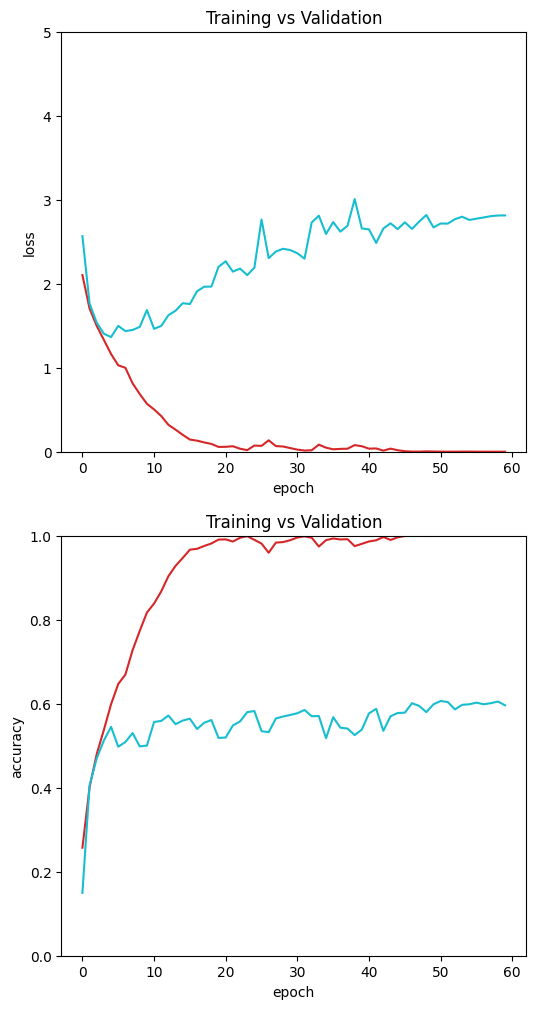

In [6]:
'''
# testing
import matplotlib.pyplot as plt

n_epochs = 4
epoch_loss = {"train" : [], "valid" : []}
epoch_accu = {"train" : [], "valid" : []}
epoch_loss["train"] = [.1, .2, .3, .4]
epoch_accu["train"] = [.2, .4, .5, .7]
epoch_loss["valid"] = [.15, .25, .35, .45]
epoch_accu["valid"] = [.25, .45, .55, .75]
'''

# Plot two figures (epoch loss and epoch accuracy) in one figure
rows, cols = 2, 1

# Base figure
figure = plt.figure(figsize=(6, 12))

'''# copy data back to cpu
for i in range(n_epochs):
    epoch_loss["train"][i] = epoch_loss["train"][i].cpu()
    epoch_accu["train"][i] = epoch_accu["train"][i].cpu()
    epoch_loss["valid"][i] = epoch_loss["valid"][i].cpu()
    epoch_accu["valid"][i] = epoch_accu["valid"][i].cpu()
'''

epoch_plt = [epoch_loss, epoch_accu]
y_limit = [5.0, 1.0]
y_label = ["loss", "accuracy"]
    
for i in range(2):
    x_1 = x_2 = range(n_epochs)
    figure.add_subplot(rows, cols, i + 1)
    plt.plot(x_1, epoch_plt[i]["train"], c="tab:red", label="train")
    plt.plot(x_2, epoch_plt[i]["valid"], c="tab:cyan", label="valid")
    plt.ylim(0.0, y_limit[i])
    plt.xlabel("epoch")
    plt.ylabel(y_label[i])
    plt.title("Training vs Validation")

plt.show()

    



## **Reference**
**This is a modification code from ML2021 HW2-1**
* Source: https://speech.ee.ntu.edu.tw/~hylee/ml/2021-spring.php